<a href="https://colab.research.google.com/github/BuxinSu/ICML_Ranking/blob/main/Notebooks/Confidence_single_iso_residual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Google Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setting**


In [ ]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 28
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch

# **Load CSV file into a pandas DataFrame**


In [ ]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])

# Load your data from a CSV file
df_review = pd.read_csv('/content/drive/MyDrive/Research/ICML_2023_Data/Final_Datafile/review_daily_anon_2023_0312.csv')
# Extract the first number from the 'rating' column based on the specific format of the rating content
df_review['rating'] = df_review['rating'].str.extract(r'^(\d+)', expand=False).astype(float)
# Extract the first number from the 'confidence' column
df_review['confidence'] = df_review['confidence'].str.extract(r'^(\d+)', expand=False).astype(float)

# **Residual vs. Variance**

In [ ]:
# Organize each block by {author: [submission, rank, score]}.
author_submission_rank_old = {}
authors = df['author_id'].unique()

for author in authors:
    author_submission_rank_old[author] = []
    submissions = df[df['author_id'] == author]['submission_id'].tolist()
    for i in range(len(submissions)):
        rank = df[(df['submission_id'] == submissions[i]) & (df['author_id'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_id'] == submissions[i]) & (df['author_id'] == author)]['rating_0312_mean'].tolist()[0]
        author_submission_rank_old[author].append((submissions[i], rank, ratings))



# Sort submissions by rank; in case of ties, sort by score.
def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
author_submission_rank_old = sort_submissions(author_submission_rank_old)



# Compute isotonic scores for each author.
author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



# For multi-author submissions, average the scores to get the isotonic score.
final_submission_list = df['submission_id'].unique()

submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in submission_new_rating:
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating





# Record residual
submission_old_rating = {}
for submission in final_submission_list:
    submission_old_rating[submission] = df_review[df_review['submission_id'] == submission]['rating'].tolist()

residual = []
for submission in submission_old_rating:
  for i in range(len(submission_old_rating[submission])):
    residual.append( submission_old_rating[submission][i] - submission_new_rating[submission] )




# Record Variance
variance = []
for submission in submission_old_rating:
  for i in range(len(submission_old_rating[submission])):
    ratings = df_review[df_review['submission_id'] == submission]['rating'].tolist()
    ratings = np.array(ratings)
    variance.append( (np.var(ratings)) )



## Plot


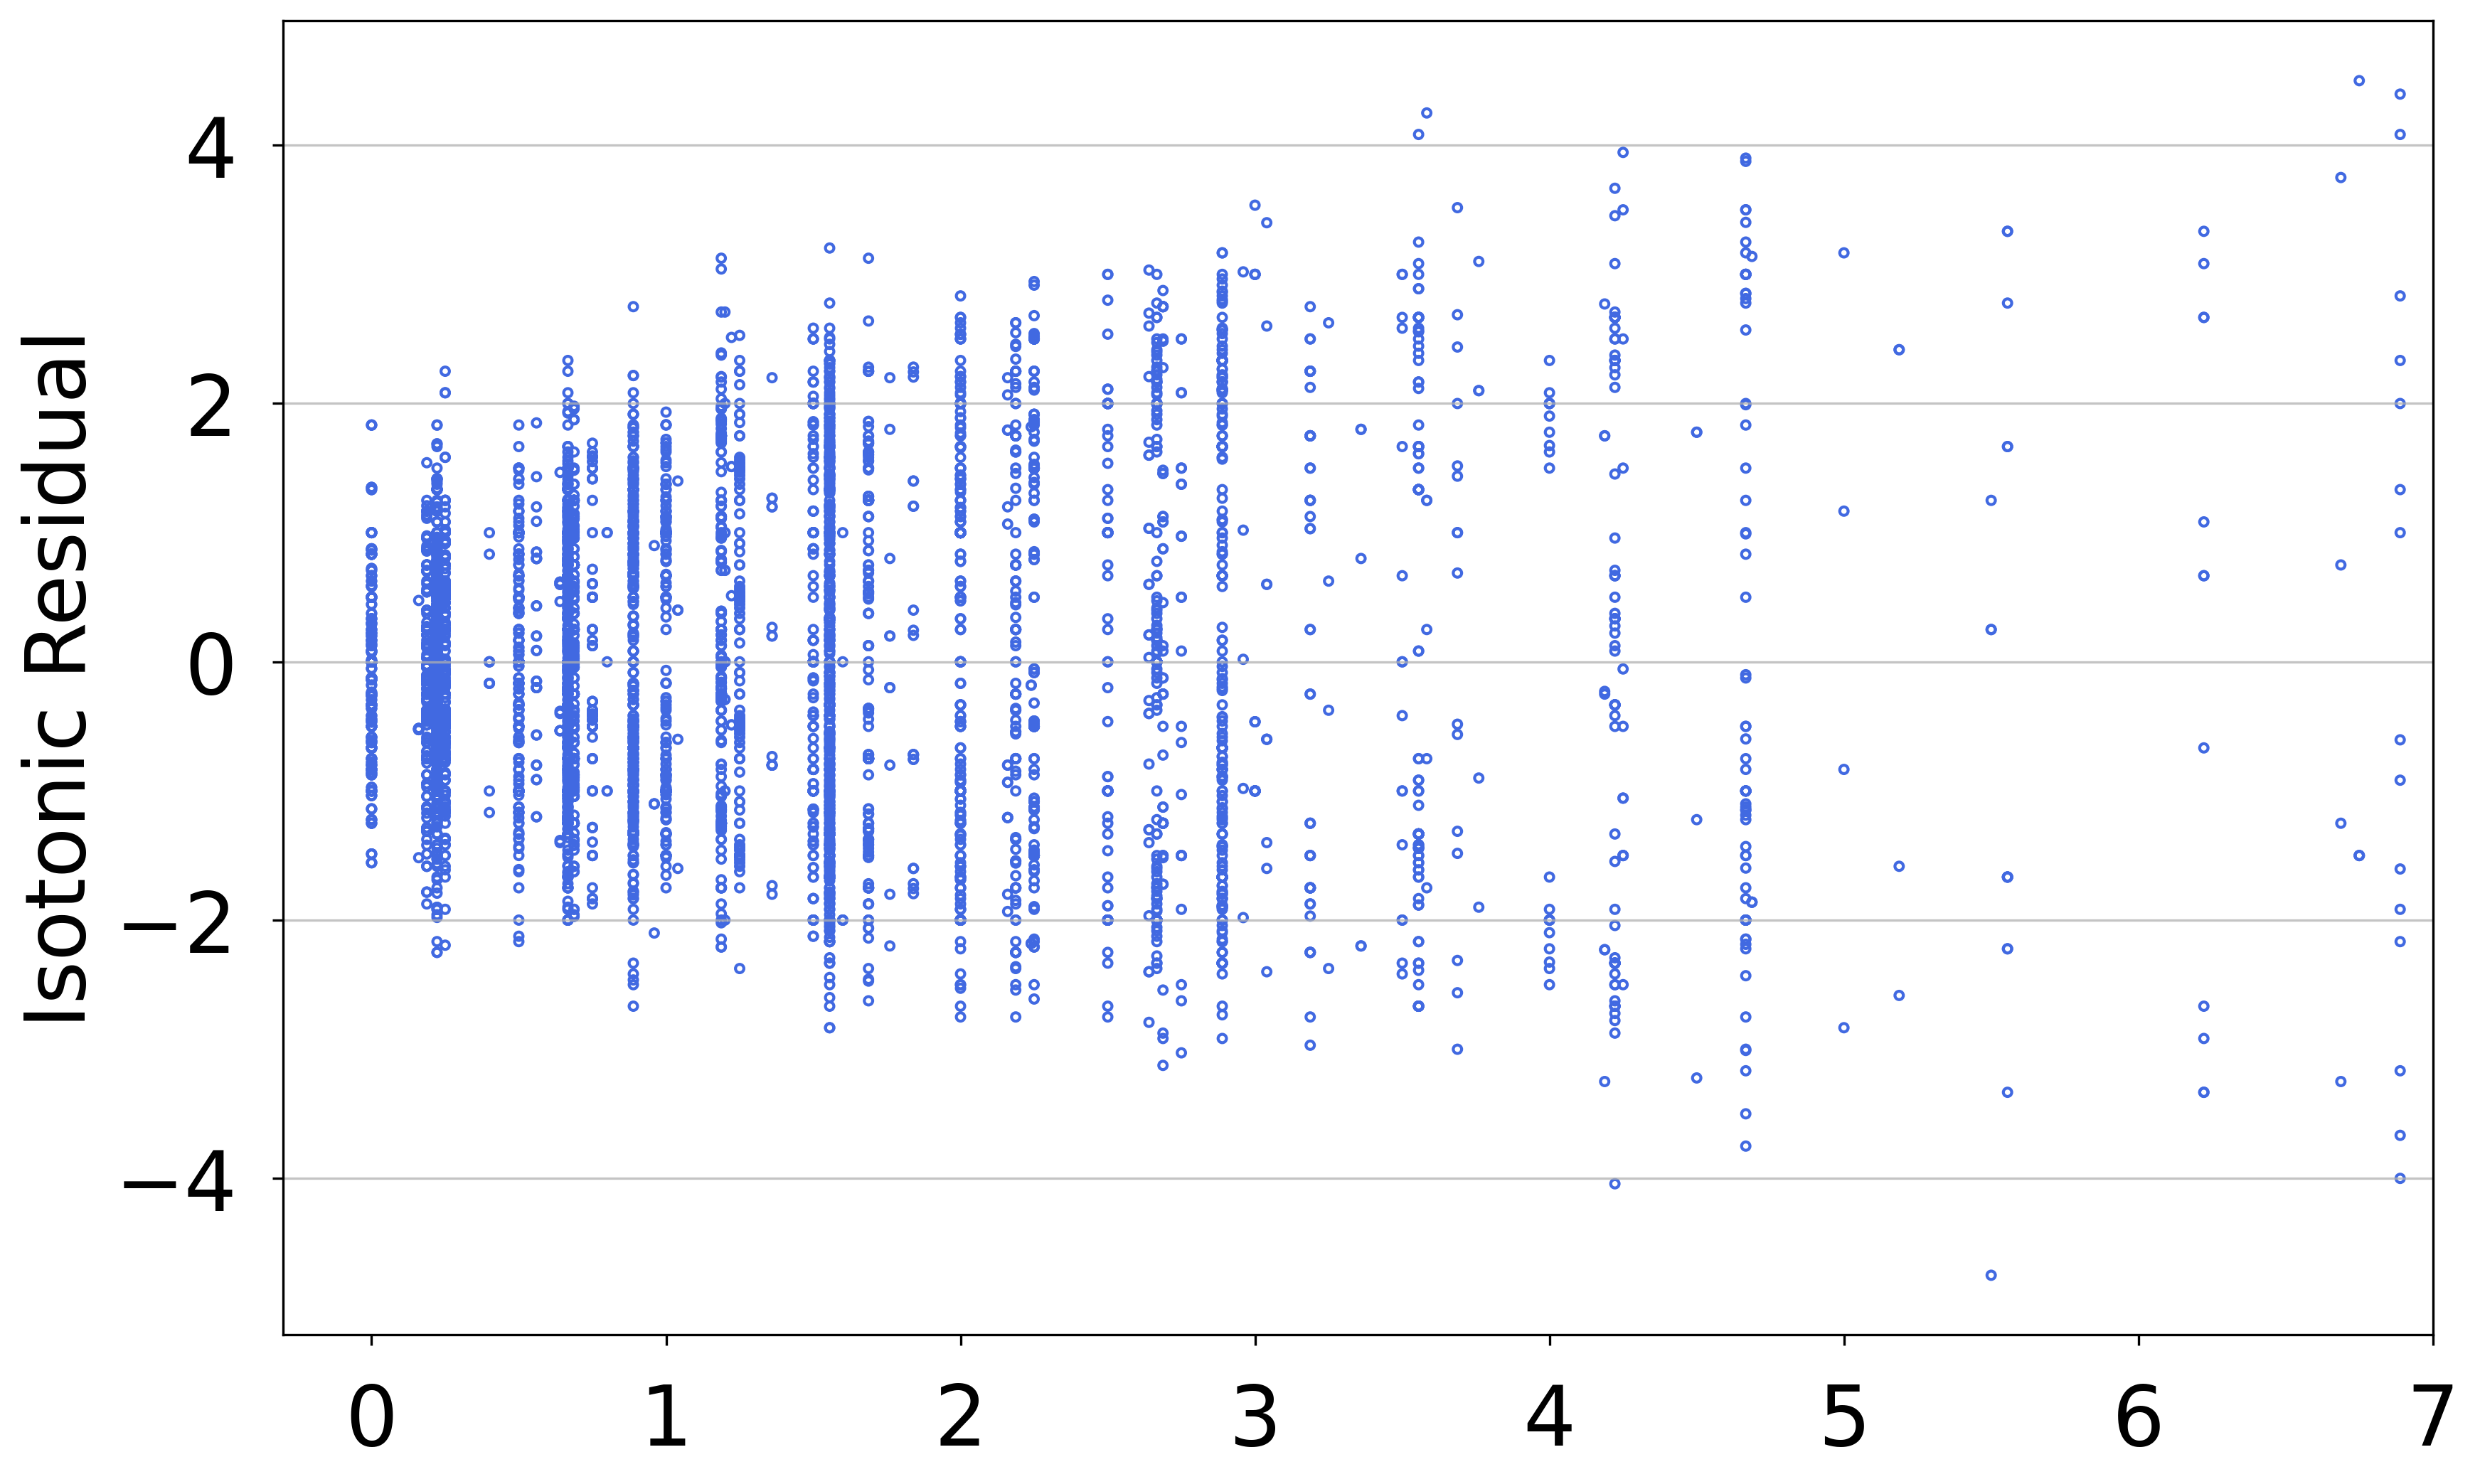

In [ ]:
plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(variance, residual, marker='o', s=8, facecolors='none', edgecolors='royalblue')
plt.xlim(-0.3,7)
# plt.xlabel('')
plt.ylabel('Isotonic Residual')
plt.grid(axis='y', alpha=0.75)
plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)
#plt.title('Variance and Individual Residual')
plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/variance_single_residual.svg", bbox_inches='tight')
plt.show()

# **Confidence vs. Variance**

In [ ]:
# Record Confidence
final_submission_list = df['submission_id'].unique()

confidence = []
final_submission = []
for i in range(len(final_submission_list)):
  confidences = df_review[df_review['submission_id'] == final_submission_list[i]]['confidence'].tolist()
  confidences = np.array(confidences)
  if np.mean(confidences) >= 3:
    confidence.append( np.mean(confidences) )
    final_submission.append(final_submission_list[i])



# Record Variance
variance = []
for i in range(len(final_submission)):
    variances = df_review[df_review['submission_id'] == final_submission_list[i]]['rating'].tolist()
    variances = np.array(variances)
    # print(variances)
    variance.append( np.var(variances) )



# Compute correlation
correlation_matrix = np.corrcoef(confidence, variance)
correlation = correlation_matrix[0, 1]
print(correlation)






0.020522401856084047


## Plot


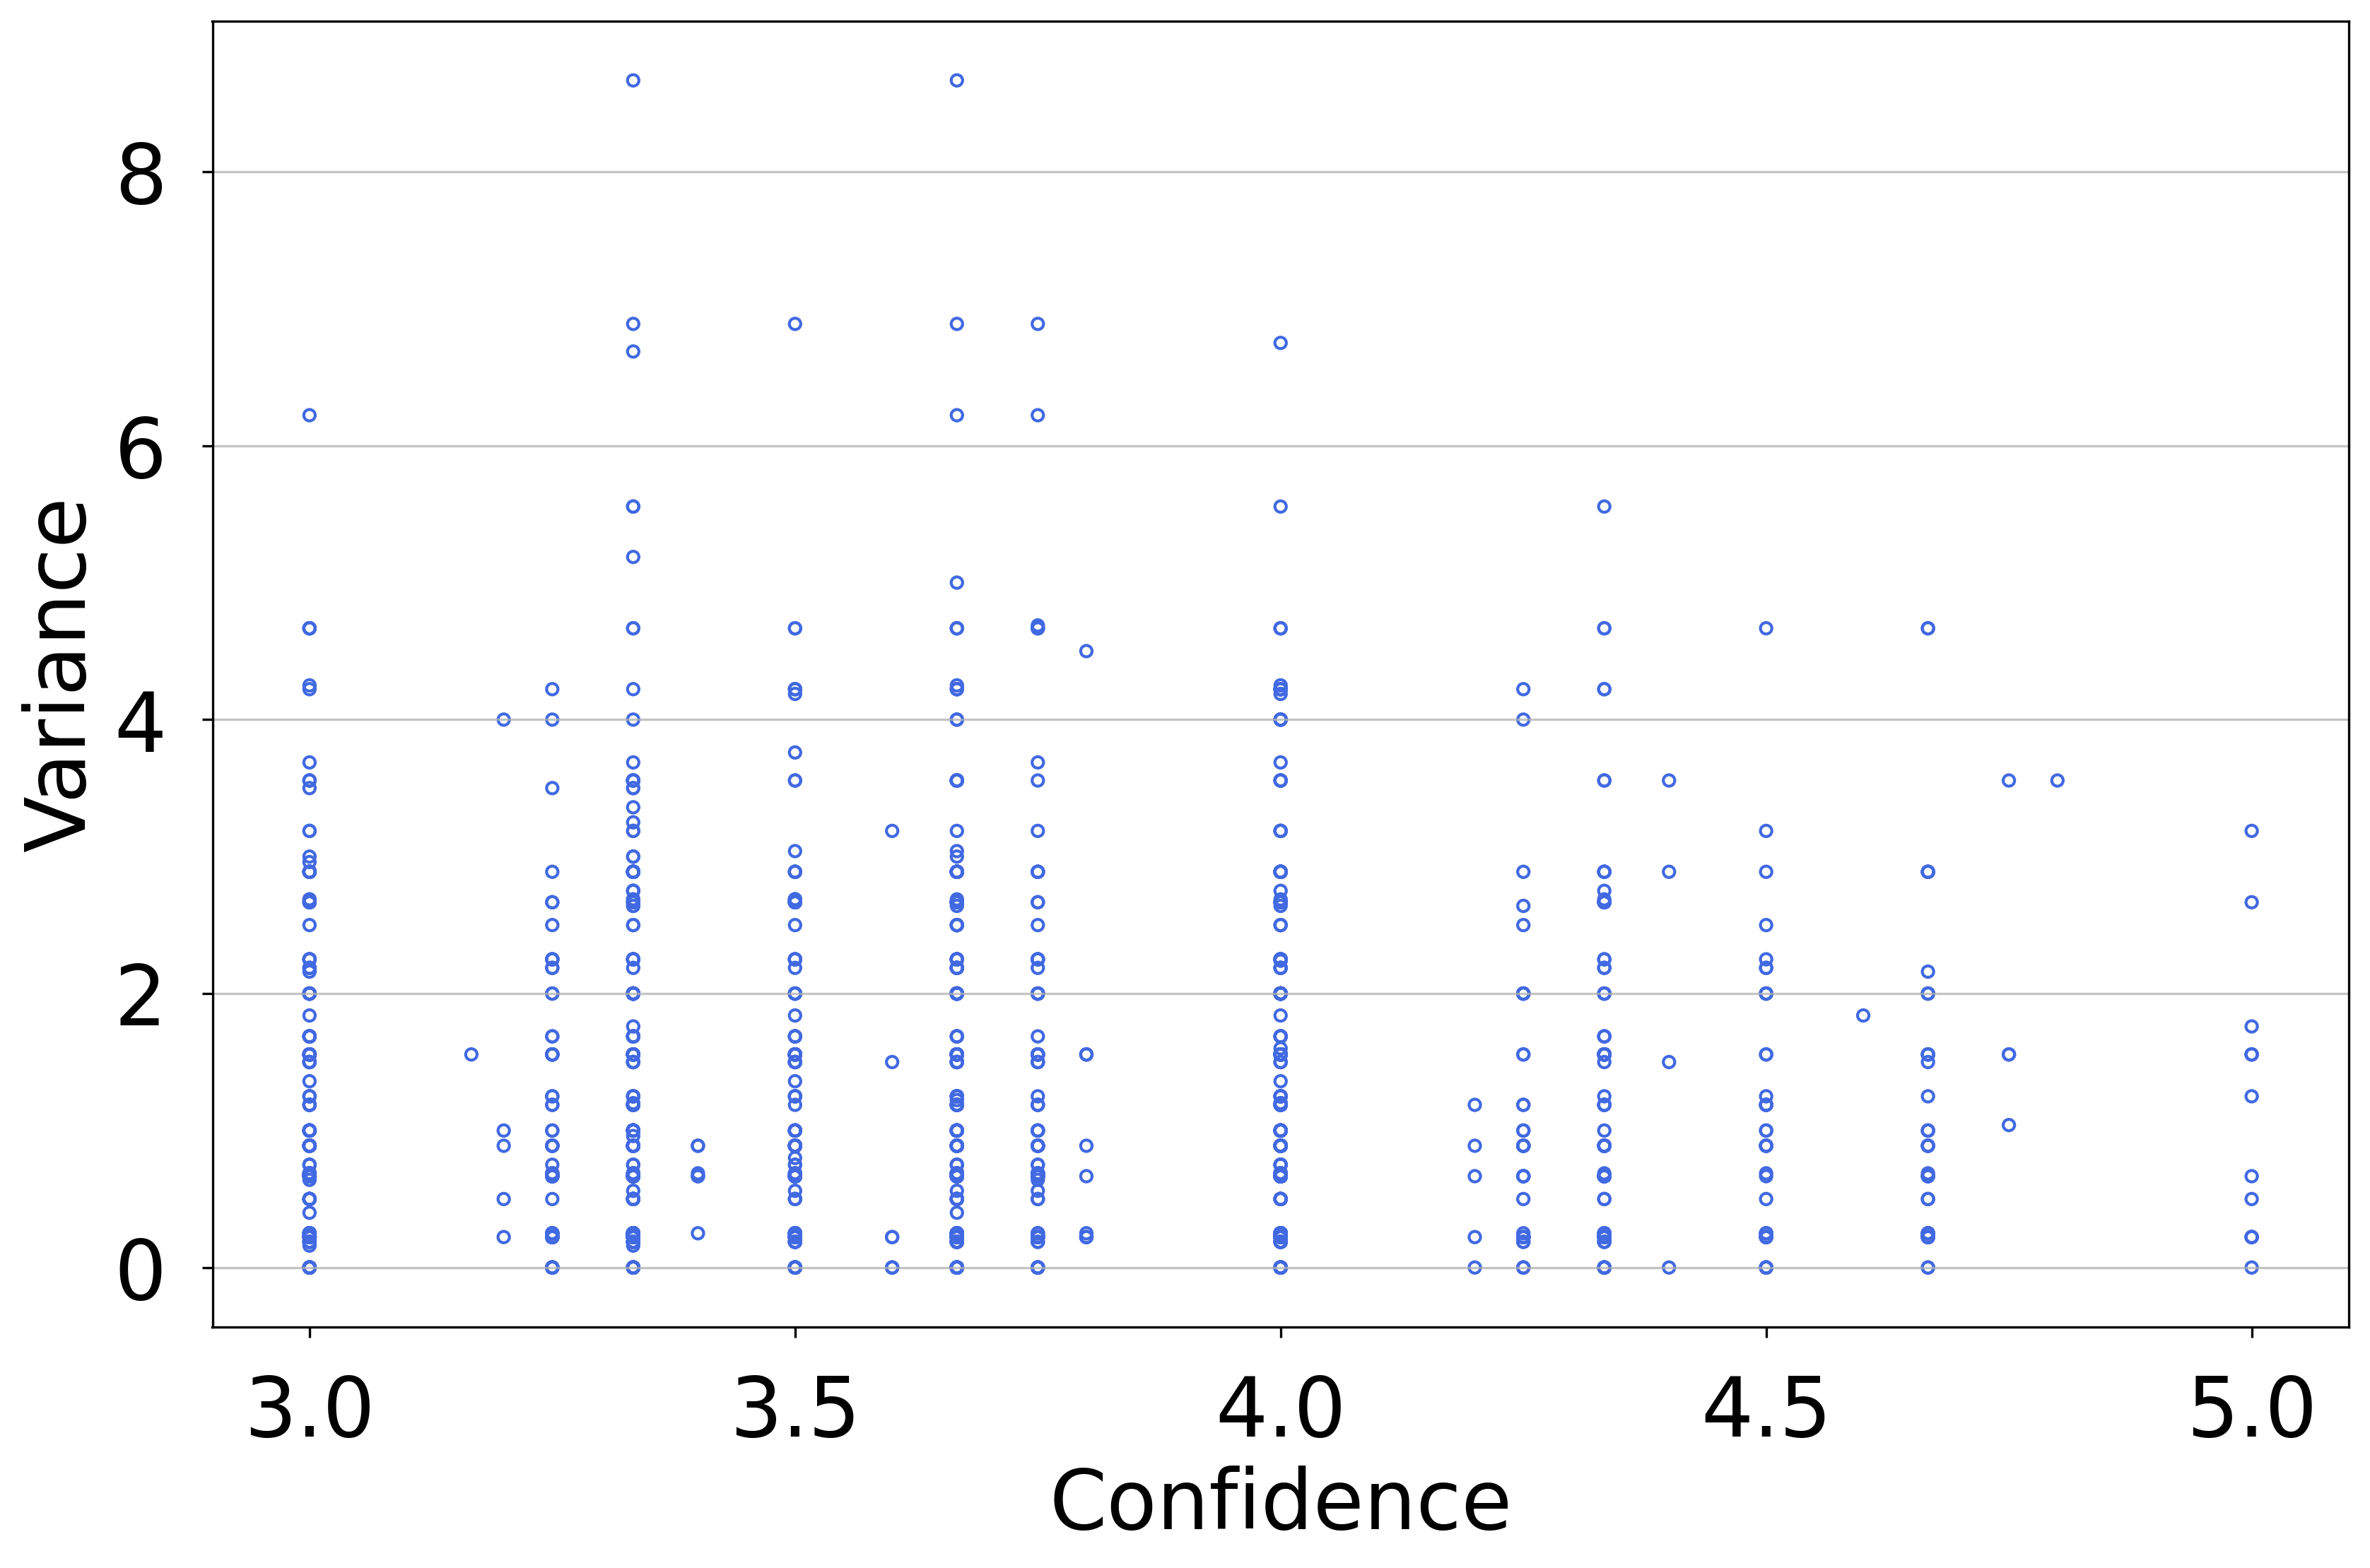

In [ ]:
plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(confidence, variance, marker='o', s=15, facecolors='none', edgecolors='royalblue')
plt.xlim(2.9, 5.1)
plt.xlabel('Confidence')
plt.ylabel('Variance')
plt.grid(axis='y', alpha=0.75)
plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)
# plt.title('Variance and Confidence')
plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/variance_confidence.svg", bbox_inches='tight')
plt.show()

# **Residual vs. Confidence**

In [ ]:
# Organize all the submissions by {author: [submission, rank, score]}.
author_submission_rank_old = {}
authors = df['author_id'].unique()

for author in authors:
    author_submission_rank_old[author] = []
    submissions = df[df['author_id'] == author]['submission_id'].tolist()
    for i in range(len(submissions)):
        rank = df[(df['submission_id'] == submissions[i]) & (df['author_id'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_id'] == submissions[i]) & (df['author_id'] == author)]['rating_0312_mean'].tolist()[0]
        author_submission_rank_old[author].append((submissions[i], rank, ratings))



# Sort submissions by rank; in case of ties, sort by score.
def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
author_submission_rank_old = sort_submissions(author_submission_rank_old)



# Compute isotonic scores for each author.
author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



# consider all the submissions with 3 reviewers
submission_list = df['submission_id'].unique()
final_submission_list = []
for submission in submission_list:
  ratings = df_review[df_review['submission_id'] == submission]['rating'].tolist()
  ratings = np.array(ratings)
  if 3 == len(ratings):
    final_submission_list.append(submission)



# Record isotonic score
submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating



# Record average score
submission_old_rating = {}
for submission in final_submission_list:
  ratings = df[df['submission_id'] == submission]['rating_0312_mean'].tolist()[0]
  submission_old_rating[submission] = ratings



# Record confidence
confidence = []
for i in range(len(final_submission_list)):
    confidences = []
    confidences = df_review[df_review['submission_id'] == final_submission_list[i]]['confidence'].tolist()
    confidences = np.array(confidences)
    confidence.append( np.mean(confidences) )



# Record residual
residual = []
for i in range(len(final_submission_list)):
    residual.append(submission_new_rating[final_submission_list[i]] - submission_old_rating[final_submission_list[i]])








## Plot


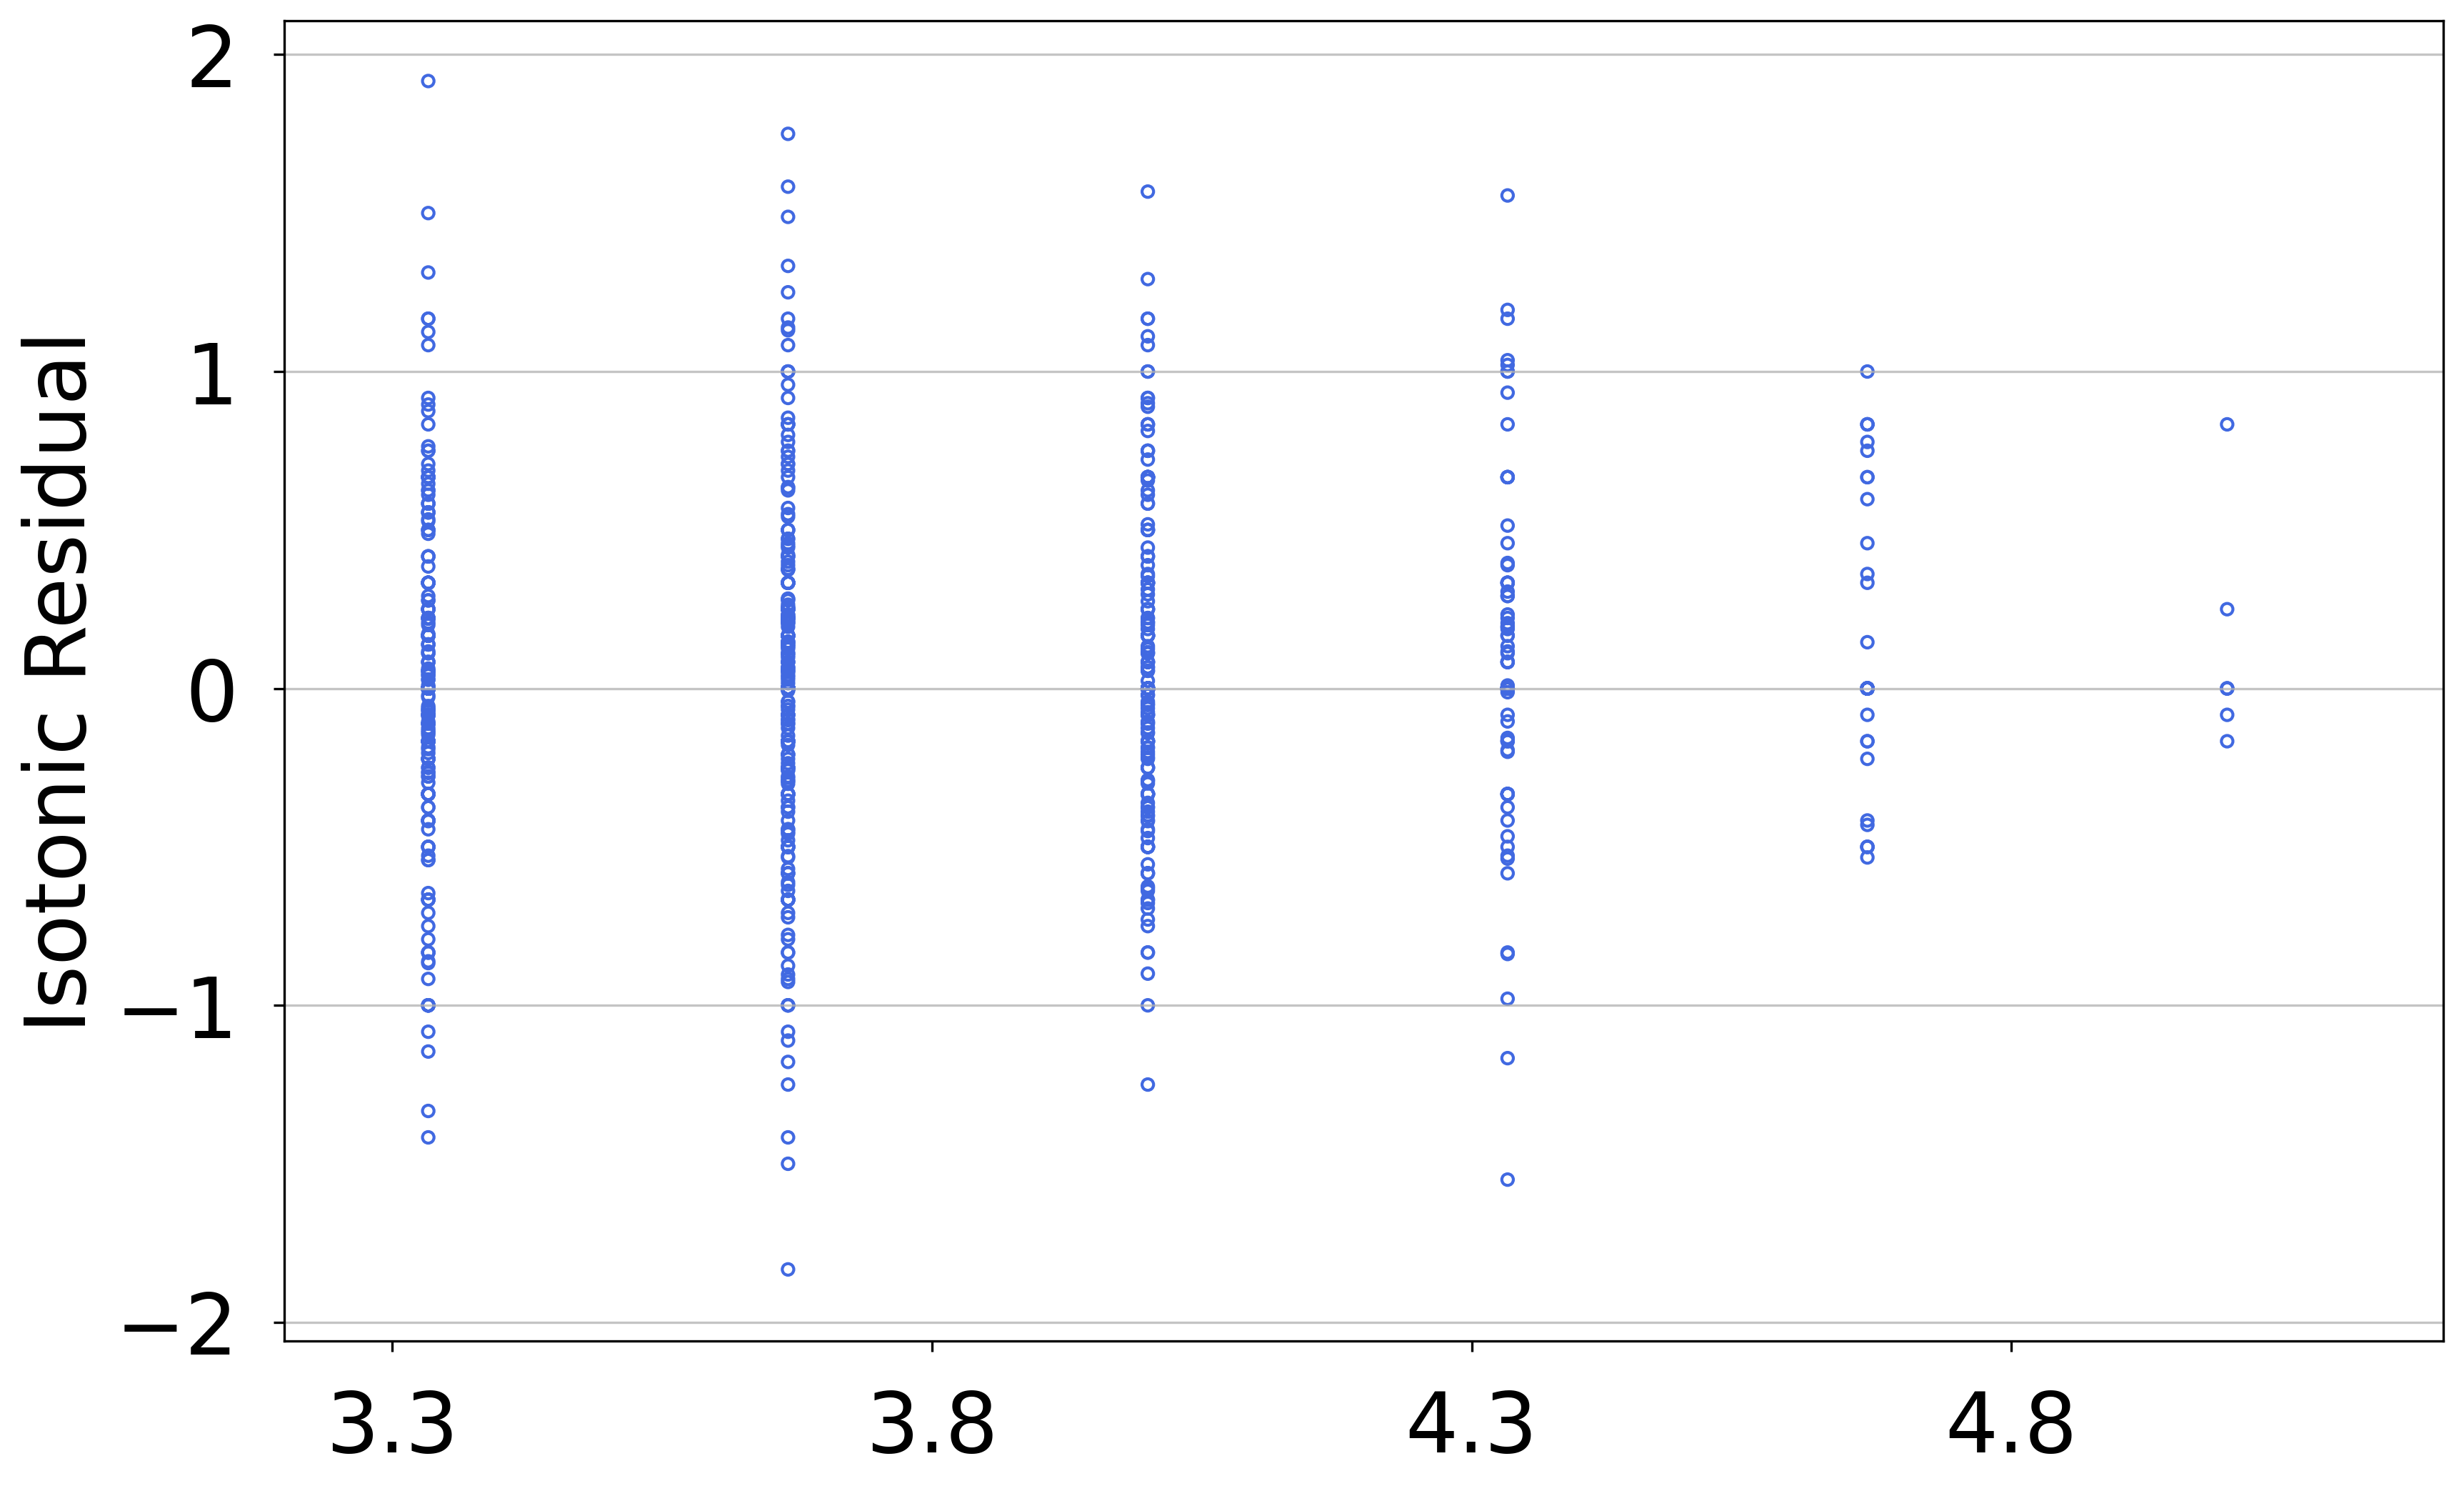

In [ ]:
plt.figure()
# Create a scatter plot for mse_1 with blue color
plt.scatter(confidence, residual, marker='o', s=15, facecolors='none', edgecolors='royalblue')
plt.xlim(3.2, 5.2)
# plt.xlabel('Review Confidence')
plt.ylabel('Isotonic Residual')
plt.xticks(np.arange(3.3, 5.3, 0.5))
plt.grid(axis='y', alpha=0.75)
plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)
#plt.title('Confidence and Mean Residual')
plt.savefig("/content/drive/MyDrive/Research/ICML_2023_Result/Figures/confidence_single_residual.svg", bbox_inches='tight')
plt.show()